# <center> Ising model: 3 Monte Carlo algorithms</center>


<hr>

## Introduction

In this lecture, we approach the statistical mechanics of the Ising model. This archetypal model undergoes an order-disorder phase transition. Here we discuss three important Monte Carlo algorithms that allows to capture the physics of this spin system far and close to the critical temperature. These algorithms are very general and can be easily extended to other spin systems, such as the XY or the Heisenberg models.



Ising spins take two values $\sigma=\pm 1$ and live on a lattice of $N$ sites $k=0... N-1$.  In the ferromagnetic case, $J>0$, spins prefer to be aligned with each other, and the energy is written as a sum between nearest neighbours ${\langle i j \rangle}$:
$$E = - J \sum_{\langle i j \rangle} \sigma_i \sigma_j  $$
The sum is over all pairs of neighbors. In a sum over pairs of neighbors, we consider each pair only once, that is, we pick either $i$, $j$ or $j, i$. 


If the system is at equilibrium with a thermal bath at inverse temperature $\beta$, the partition function of the spins writes
$$ Z= \sum_{\sigma_1=\pm 1, \sigma_2 =\pm 1,\ldots, \sigma_{N-1} =\pm 1} e^{-\beta E} = \sum_{\sigma} e^{-\beta E}$$
Here $\sum_{\sigma}$ indicates the sum over all configurations
* How many terms we have in this sum?

### Observables

If it is possible to take care of this huge sum all observables can be estimated and expressed either as mean values or fluctuations. Let's list some of them:
- Internal Energy
$$\langle E \rangle =\sum_\sigma E \frac{e^{-\beta E}}{Z}$$
- Magnetization
$$\langle M \rangle =\sum_\sigma \left(\sum_{i=0}^{N-1} \sigma_i\right) \frac{e^{-\beta E}}{Z}$$
The symmetry $\sigma\to -\sigma$ of the energy imposes $\langle M \rangle=0$ at all temperatures. For our porpouses it is more convenient to define
$$\langle |M| \rangle =\sum_\sigma   \left|\left(\sum_{i=0}^{N-1} \sigma_i\right) \right| \frac{e^{-\beta E}}{Z}$$
- The specific heat
$$c_V=\frac{1}{N} \frac{\partial \langle E\rangle}{\partial T} =\frac{\beta^2}{N} \left( \langle E^2\rangle -\langle E \rangle^2\right)$$

### Numerical strategy 1: Exact Enumeration

The first strategy we can use is exact enumeration.

* How many possible energy we have in a system of $N$ spins? (in d=2 square lattive with periodic boundary conditions energies goes from $-2 E$ to $2 E$)

The complexity of this technique is exponential in the system size. 
A central quantity to compute is the number of configurations at energy $E$, namely ${\cal N}(E)$. If ${\cal N}(E)$ is known, many thermodynamic quantities can be re-organized in a sum of a small number of terms. For example:
$$Z= \sum_E {\cal N}(E) e^{-\beta E}$$

* How many terms you have in this sum?

The best algorithm to enumerate binary variables is the Gray Code. In the Gray code sequence two successive configuations differ in only one bit. 
A python implementation of the Gray code  <a href="http://introcs.cs.princeton.edu/python/23recursion/graycode.py.html"> graycode.py</a>  can be found below:


In [ ]:
def genCode(n):
    if n == 0:
        return ['']
    
    code1 = genCode(n-1)
    print (code1, len(code1))
    code2 = []
    for codeWord in code1:
        code2 = [codeWord] + code2
    print (code2,len(code2))    
    for i in range(len(code1)):
        code1[i] += '0'
    for i in range(len(code2)):
        code2[i] += '1'
    return code1 + code2  

n = 4
code = genCode(n)
print (code)



[''] 1
[''] 1
['0', '1'] 2
['1', '0'] 2
['00', '10', '11', '01'] 4
['01', '11', '10', '00'] 4
['000', '100', '110', '010', '011', '111', '101', '001'] 8
['001', '101', '111', '011', '010', '110', '100', '000'] 8
['0000', '1000', '1100', '0100', '0110', '1110', '1010', '0010', '0011', '1011', '1111', '0111', '0101', '1101', '1001', '0001']


Even with this excellent method, exact enumeration remains a task which grows exponentially with the system size. We are constrained to systems with less then $N=40$ spins.

### Numerical strategy 2:  The Monte Carlo

For concretness we set $J=1$ and focus on the  $d=2$ Ising model defined square lattice. From Onsager's exact solution we know that the ferromagnetic transition occurs at
$$\beta_c= \frac{\ln(1+\sqrt{2})}{2}=0.44407\ldots$$

* Step 1: Let us first define the list of neghbours in  the $d=2$ lattice of side $L$. 

The function neighbors determines which sites of the lattice are the neighbors (right, up, left, down) of the current site.

In [ ]:
def neighbors(i, j , L):
    return [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]

An idea for plotting configurations. 

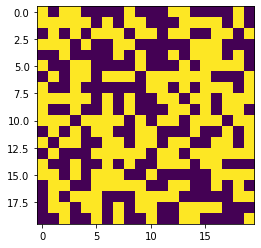

In [3]:
import numpy as np
import itertools as it
import matplotlib.pylab as plt
L = 20
spin_configuration = np.random.choice([-1,1], size=(L,L))
#print(spin_configuration)
plt.imshow(spin_configuration)

### Algorithm 1: Standard Metropolis

* Think how it should be defined and prove that it works

* For the implementation, it is convenient to define the molecular field acting on the spin $k$:
$$ h= \sum_j \sigma_j \quad \text{with} \; j\; \text{nearest neighbour of} \; k  $$


### <center> Metroplis - Hastings </center>

The detailed balance condition writes
$$ \pi(a) p_{a \to b} = \pi(b) p_{b \to a}$$
But we should be carful: the MCMC dynamics is not connecting $a$ with any configuration $b$. ONLY a tiny fraction of configuration $b$ is dynamically connected to $a$. We can define the a priori probability, ${\cal A}_{a \to b}$.

${\cal A}_{a \to b}$ is zero if the configuration $b$ cannot be proposed starting from $a$ and gives the probability to propose the configuration $b$ otherwise. Note that
$$p_{b \to a}= p_{a \to b}^{\text{acc.}} {\cal A}_{a \to b}$$
and the probability of accpeting the move is then given by the Metropolis-Hastings prescription:
$$ p_{a \to b}^{\text{acc.}}=\min(1,\frac{\pi(b) {\cal A}_{b \to a}}{\pi(a)\, {\cal A}_{a \to b} })$$

* In standard Metropolis we take ${\cal A}_{b \to a}= {\cal A}_{a \to b}$

Below we find two algorithms that take different prescriptions: the Heat Bath and the Cluster

### Algorithm 2: Heat bath
In the heat bath the select spin is thermalized at the temperature $\beta$ and the molecular field $h$. The important quantity is
$$\pi_+= \frac{1}{1+e^{- 2\beta h}} \quad \pi_-= \frac{1}{1+e^{ 2\beta h}}$$
* Note that the algorithm is rejection free
* Prove that it works

### Algorithm 3: Cluster Algorithm

Single-spin-flip Monte Carlo algorithms are slow close to $T_c$, because the histogram of essential values of the magnetization is wide and the step width of the magnetization is small. To sample faster, we must foster moves which change the magnetization by more than $\pm 2$. However, using the single-spin-flip algorithm in parallel, on several sites at a time, only hikes up the rejection rate. Neither can we, so to speak, solidly connect all neighboring spins of the same orientation and flip them all at once. Doing so would quickly lead to a perfectly aligned state, from which there would be no escape.
Swendsen - Wang and Wolff,
have proposed a cluster algorithm, which has been the role models for about a generation of research.

Starting from an initial site $k$, one adds neighboring sites with probability p until the construction stops. 
* Show that for $p=1-e^{-2 \beta}$ the costruction becomes rejection free. 

In the Wolff implementation one just flip sthe constructed cluster (see code below). In the Swendsen and Wang version all spins are grouped in clusters so that each spin belong to a given cluster. Then it pick one cluster at random ad flip it. Both version are useful.

* Which one has a shorter correlation time?

In [4]:
def wolff(config, T):
    
    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = [(i,j)]
    cluster = [(i,j)]
    n_cluster = 1
    
    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)

    # grow the cluster
    while border != []:
        i, j = border.pop()
        for u, v in neighbors(i, j, L):
            if config[u,v] == config[i,j] and (u,v) not in cluster and np.random.rand() < p:
                border.append((u,v))
                cluster.append((u,v))
                n_cluster += 1

    # flip the spins in the cluster
    for i, j in cluster: 
        config[i,j] *= -1


References

* R. H. Swendsen, J. S. Wang (1987) Nonuniversal critical-dynamics in
Monte-Carlo simulations, Physical Review Letters 58, 86–88
* U. Wolff (1989) Collective Monte-Carlo updating for spin systems, Physical Review Letters 62, 361–364
* SMAC pag. 257